<a href="https://colab.research.google.com/github/dfsj66011/learning_note/blob/master/tensorflow_tutorial/Research_and_Experimentation/custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom training: basics

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/eager/custom_training"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In the previous tutorial we covered the TensorFlow APIs for automatic differentiation, a basic building block for machine learning.
In this tutorial we will use the TensorFlow primitives introduced in the prior tutorials to do some simple machine learning.

TensorFlow also includes a higher-level neural networks API (`tf.keras`) which provides useful abstractions to reduce boilerplate. We strongly recommend those higher level APIs for people working with neural networks. However, in this short tutorial we cover neural network training from first principles to establish a strong foundation.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.enable_eager_execution()

## Variables

Tensors in TensorFlow are immutable stateless objects. Machine learning models, however, need to have changing state: as your model trains, the same code to compute predictions should behave differently over time (hopefully with a lower loss!). To represent this state which needs to change over the course of your computation, you can choose to rely on the fact that Python is a stateful programming language:


In [11]:
# Using python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow, however, has stateful operations built in, and these are often more pleasant to use than low-level Python representations of your state. To represent weights in a model, for example, it's often convenient and efficient to use TensorFlow variables.

A Variable is an object which stores a value and, when used in a TensorFlow computation, will implicitly read from this stored value. There are operations (`tf.assign_sub`, `tf.scatter_update`, etc) which manipulate the value stored in a TensorFlow variable.

In [0]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

# Re-assign the value
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow operation like tf.square() and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

Computations using Variables are automatically traced when computing gradients. For Variables representing embeddings TensorFlow will do sparse updates by default, which are more computation and memory efficient.

Using Variables is also a way to quickly let a reader of your code know that this piece of state is mutable.

## Example: Fitting a linear model

Let's now put the few concepts we have so far ---`Tensor`, `GradientTape`, `Variable` --- to build and train a simple model. This typically involves a few steps:

1. Define the model.
2. Define a loss function.
3. Obtain training data.
4. Run through the training data and use an "optimizer" to adjust the variables to fit the data.

In this tutorial, we'll walk through a trivial example of a simple linear model: `f(x) = x * W + b`, which has two variables - `W` and `b`. Furthermore, we'll synthesize data such that a well trained model would have `W = 3.0` and `b = 2.0`.

### Define the model

Let's define a simple class to encapsulate the variables and the computation.

In [0]:
class Model(object):
    def __init__(self):
        # Initialize variable to (5.0, 0.0)
        # In practice, these should be initialized to random values.
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

### Define a loss function

A loss function measures how well the output of a model for a given input matches the desired output. Let's use the standard L2 loss.

In [0]:
def loss(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

### Obtain training data

Let's synthesize the training data with some noise.

In [0]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random_normal(shape=[NUM_EXAMPLES])
noise   = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

Before we train the model let's visualize where the model stands right now. We'll plot the model's predictions in red and the training data in blue.

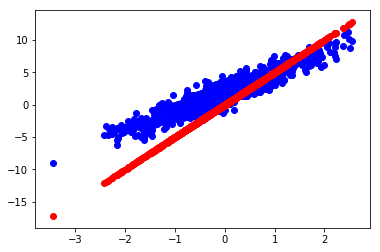

Current loss: 
8.314501


In [16]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

### Define a training loop

We now have our network and our training data. Let's train it, i.e., use the training data to update the model's variables (`W` and `b`) so that the loss goes down using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer` implementations. We'd highly recommend using those implementations, but in the spirit of building from first principles, in this particular example we will implement the basic math ourselves.

In [0]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
    dW, db = t.gradient(current_loss, [model.W, model.b])
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

Finally, let's repeatedly run through the training data and see how `W` and `b` evolve.

Epoch  0: W=5.00 b=0.00, loss=8.31450
Epoch  1: W=4.63 b=0.38, loss=5.79260
Epoch  2: W=4.34 b=0.69, loss=4.13934
Epoch  3: W=4.09 b=0.93, loss=3.05526
Epoch  4: W=3.89 b=1.13, loss=2.34422
Epoch  5: W=3.73 b=1.29, loss=1.87773
Epoch  6: W=3.60 b=1.42, loss=1.57162
Epoch  7: W=3.49 b=1.52, loss=1.37069
Epoch  8: W=3.40 b=1.60, loss=1.23877
Epoch  9: W=3.33 b=1.67, loss=1.15214


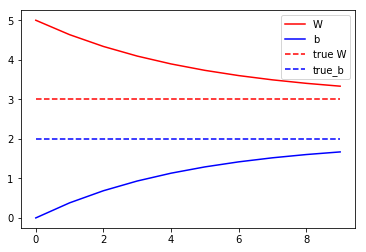

In [18]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)

    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' % 
          (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r', epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--', [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()


## Next Steps

In this tutorial we covered `Variable`s and built and trained a simple linear model using the TensorFlow primitives discussed so far.

In theory, this is pretty much all you need to use TensorFlow for your machine learning research.
In practice, particularly for neural networks, the higher level APIs like `tf.keras` will be much more convenient since it provides higher level building blocks (called "layers"), utilities to save and restore state, a suite of loss functions, a suite of optimization strategies etc.
